<a href="https://colab.research.google.com/github/maheenna/text-analysis-pipeline/blob/main/Text_Analysis_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U langchain langchain-google-genai langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.8/160.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.0/760.0 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.7/407.7 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [2]:
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm : ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model='gemini-1.5-flash',
    api_key= gemini_api_key,
    temperature=0.2,
    convert_system_message_to_human=True
)

In [13]:
import textwrap
from IPython.display import Markdown

def to_markdown(text):
  """Converts input text to markdown format, replacing bullet points with asterisks and indenting."""
  # Access the 'output' value from the AddableValuesDict
  text_to_modify = text['output']
  # Apply replace to the accessed string
  text_to_modify = text_to_modify.replace('•','*')
  return Markdown(textwrap.indent(text_to_modify,'>',predicate=lambda _: True))


In [5]:
# making a schema using class
from typing_extensions import TypedDict

class TextAnalyze(TypedDict):
  prompt:str
  output:str


In [6]:
# custom prompt template
template = """
use the prompt {input} which is pass by user and analyze the text in such a way that
1. seperate the keyword from prompt and show these keywords in output
2. identify that the prompt belongs to which topics and show it with topic heading in output
3. identify that the what is the language of prompt and show it with language heading in output
then answer the question which is passed in prompt with answer heading in output
"""

In [7]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

QA_CHAIN_PROMPT = PromptTemplate.from_template(template)
llm_chain = LLMChain(prompt=QA_CHAIN_PROMPT, llm=llm)


<ipython-input-7-914dfebe8141>:5: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  llm_chain = LLMChain(prompt=QA_CHAIN_PROMPT, llm=llm)


In [8]:
def node_1(state:TextAnalyze):
  print("The Prompt was this: ", state)
  user_input = state['prompt']

  response = llm_chain.run(input=user_input)
  return {"output":response}


In [9]:
from langgraph.graph import StateGraph,START,END
from langgraph.graph.state import CompiledStateGraph

builder:StateGraph = StateGraph(state_schema=TextAnalyze)
builder.add_node("node_1",node_1)

builder.add_edge(START,"node_1")
builder.add_edge("node_1",END)

graph:CompiledStateGraph = builder.compile()

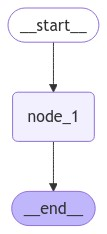

In [10]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
result = graph.invoke({"prompt":"what is the capital of Pakistan?"})


The Prompt was this:  {'prompt': 'what is the capital of Pakistan?'}


<ipython-input-8-c46f1c3fd123>:5: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm_chain.run(input=user_input)
/usr/local/lib/python3.10/dist-packages/langchain_google_genai/chat_models.py:391: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


In [15]:
to_markdown(result)

>## Text Analysis:
>
>**Keywords:** capital, Pakistan
>
>**Topic:** Geography, Countries, Capitals
>
>**Language:** English
>
>## Answer:
>
>**Answer:** The capital of Pakistan is **Islamabad**. 
